#  **Testing Gaussian EP on a given RBM**


In [34]:
using Pkg
using Plots
using Revise
using DelimitedFiles
using BenchmarkTools

In [35]:
#include("../src/GaussianEP.jl")
#using .GaussianEP
include("../Sampling/Sampling.jl")
Pkg.activate("../../GaussianEP/")
using GaussianEP

 Activating environment at `~/src/GaussianEP/Project.toml`


In [36]:
# Number of visible and hidden units, Gaussian weigths
N = 8
M = 3
w = randn(N,M)
y = zeros(N+M)
H = [GaussianEP.TermRBM(w,y,1.0)];

# (Pv, Ph) = (Gaussian - Gaussian) priors

In [37]:
μv = 3.0; βv = 5.0;
μh = 5.0; βh = 4.0;

Pv = [GaussianEP.GaussianPrior(μv, βv, 0.0) for i = 1:N];
Ph = [GaussianEP.GaussianPrior(μh, βh, 0.0) for i = 1:M];


In [38]:
out = GaussianEP.expectation_propagation(H, Pv, Ph, nprint = 100);

it: 100 Δav: 2.635643753223782e-5 Δgrad: 0.0


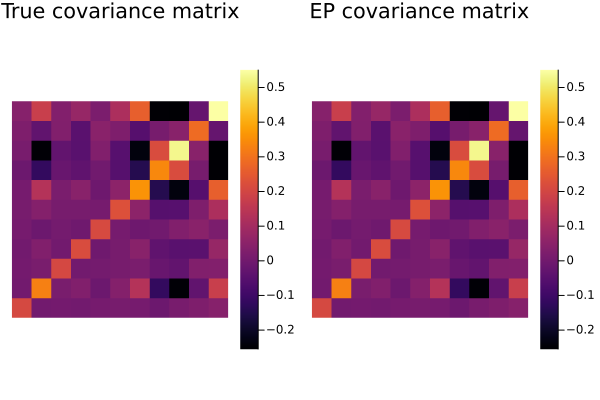

In [39]:
using Plots

Σan = GaussianEP.compute_analytic(w,Pv,Ph)
p1 = heatmap(Σan, aspect_ratio=1, ticks= :false, showaxis = :false, title="True covariance matrix", titlelocation=:center)
p2 = heatmap(out.state.Σ, aspect_ratio=1, ticks= :false, showaxis =:false, title="EP covariance matrix", titlelocation=:center)
Plots.plot(p1,p2)

# (Pv, Ph) = (Binary - Gaussian) priors

In [40]:
x0v = 0.0; x1v = 1.0; ρ = 0.9;
μh = 0.5; βh = 3.0; 
Pv = nothing; Ph = nothing;
Pv = [GaussianEP.BinaryPrior(x0v, x1v, ρ) for i = 1:N]
Ph = [GaussianEP.GaussianPrior(μh, βh, 0.0) for j = 1:M];


In [41]:
out = GaussianEP.expectation_propagation(H, Pv, Ph, epsconv = 1e-7, maxiter=100000);
cov_ep = zeros(N,M)
for i = 1:N, j = 1:M
	cov_ep[i,j] = out.state.Σ[i,N+j] + out.state.av[i] * out.state.av[N+j]
end

it: 100 Δav: 3.848532460493104e-6 Δgrad: 0.0


In [42]:
av_an, va_an, cov_an = GaussianEP.compute_analytic(w, Pv, Ph);

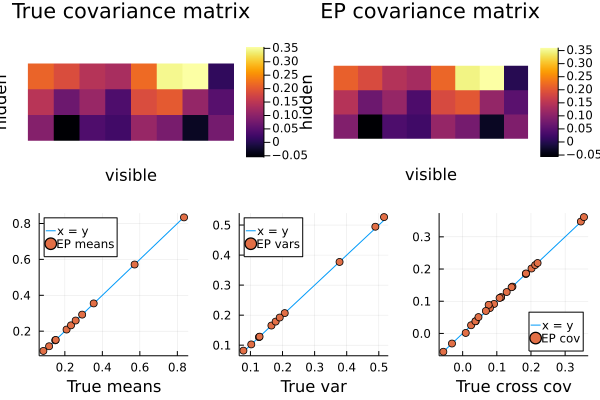

In [43]:
p1 = heatmap(cov_an', aspect_ratio=1, ticks= :false, showaxis = :false, xlabel = "visible", ylabel = "hidden" ,title="True covariance matrix", titlelocation=:center)
p2 = heatmap(cov_ep', aspect_ratio=1, ticks= :false, xlabel = "visible", ylabel = "hidden", showaxis =:false,  title="EP covariance matrix", titlelocation=:center)
p3 = Plots.plot(av_an, av_an, label = "x = y") 
p3 = Plots.plot!(av_an, out.av, seriestype = :scatter, label = "EP means", legend = :topleft, xlabel = "True means")
p4 = Plots.plot(va_an, va_an, label = "x = y")
p4 = Plots.plot!(va_an, out.va, seriestype = :scatter, label = "EP vars", legend = :topleft, xlabel = "True var")
p5 = Plots.plot(vec(cov_an), vec(cov_an), label = "x = y")
p5 = Plots.plot!(vec(cov_an), vec(cov_ep), seriestype = :scatter, label = "EP cov", legend = :bottomright, xlabel = "True cross cov")
l = @layout [a b; c d e]
Plots.plot(p1,p2,p3, p4, p5, layout = l)

In [44]:
Pv = [Sampling.BinaryPrior(x0v, x1v, ρ) for i = 1:N]
Ph = [Sampling.GaussianPrior(μh, βh, 0.0) for j = 1:M]
P0mc = vcat(Pv,Ph);

 11.766380 seconds (220.37 M allocations: 12.534 GiB, 14.26% gc time)


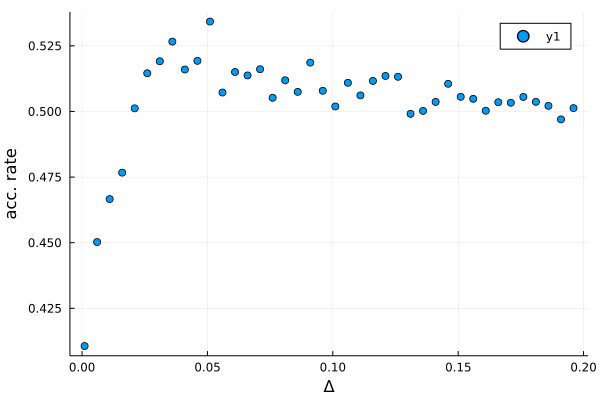

In [45]:
# Get acceptance rate ~ 0.5
Δ_vec = collect(0.001:0.005:0.2)
@time acc_tab = Sampling.MC_Δ_scan(Δ_vec,w,P0mc,10^5)
plot(acc_tab[:,1], acc_tab[:,2], xlabel="Δ", ylabel="acc. rate", seriestype = :scatter)

  0.450908 seconds (772.33 k allocations: 100.856 MiB, 4.16% gc time)


┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: [:identity, :log10]
└ @ Plots /home/an-na/.julia/packages/Plots/J70Ph/src/args.jl:1632


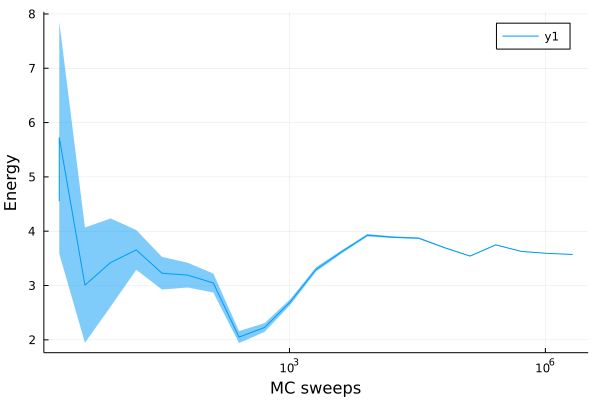

In [46]:
# Get thermalization time

Δ = 0.05
nblocks = 22
mc_energy = Sampling.MC_t_therm(nblocks, w, P0mc, Δ) 
@time bl_tab = Sampling.block_anal(nblocks, mc_energy)

p1 = plot(bl_tab[:,1], bl_tab[:,2], ribbon=bl_tab[:,3],fillalpha=.5, xscale =:log, xlabel="MC sweeps", ylabel="Energy") 
plot(p1)


In [47]:
# Sampling using MCMC
bl_tab = nothing
Nconf = 10^6
Twait = 10^6
@time mc_out = Sampling.MC_sim(w, P0mc, Twait, Δ; N_iter=Nconf);

  6.741902 seconds (110.14 M allocations: 6.347 GiB, 15.63% gc time)


In [48]:
# Compute statistics

@time av_mc, va_mc, cov_mc = Sampling.compute_statistics(mc_out, N, M);

  0.262825 seconds (148 allocations: 549.323 MiB, 12.30% gc time)


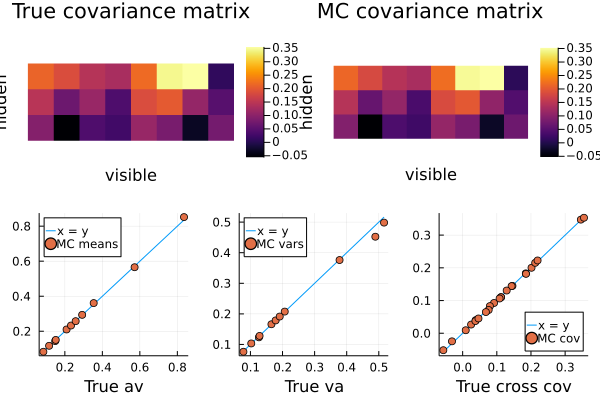

In [49]:
p1 = heatmap(cov_an', aspect_ratio=1, ticks= :false, showaxis = :false, xlabel = "visible", ylabel = "hidden" ,title="True covariance matrix", titlelocation=:center)
p2 = heatmap(cov_mc', aspect_ratio=1, ticks= :false, xlabel = "visible", ylabel = "hidden", showaxis =:false,  title="MC covariance matrix", titlelocation=:center)
p3 = Plots.plot(av_an, av_an, label = "x = y") 
p3 = Plots.plot!(av_an, av_mc, seriestype = :scatter, label = "MC means", legend = :topleft, xlabel = "True av")
p4 = Plots.plot(va_an, va_an, label = "x = y")
p4 = Plots.plot!(va_an, va_mc, seriestype = :scatter, label = "MC vars", legend = :topleft, xlabel = "True va")
p5 = Plots.plot(vec(cov_an), vec(cov_an), label = "x = y")
p5 = Plots.plot!(vec(cov_an), vec(cov_mc), seriestype = :scatter, label = "MC cov", legend = :bottomright, xlabel = "True cross cov")
l = @layout [a b; c d e]
Plots.plot(p1,p2,p3, p4, p5, layout = l)

# (Pv, Ph) = (Gaussian, ReLu) Priors

In [50]:

# Number of visible and hidden units, Gaussian weigths
N = 100
M = 10
w = randn(N,M)
y = zeros(N+M)
H = [GaussianEP.TermRBM(w,y,1.0)];
γ = 50.0
θ = 1.0
μv = 0.0; βv = 10.0; # βv needs to be large

Pv = [GaussianEP.GaussianPrior(μv, βv, 0.0) for i = 1:N];
Ph = [GaussianEP.ReLUPrior(γ, θ, 1e-2, 0.0) for j = 1:M ];

In [51]:
out = GaussianEP.expectation_propagation(H, Pv, Ph, nprint = 50, epsconv = 1e-5, maxiter = 100000)

cov_ep = zeros(N,M)
for i = 1:N, j = 1:M
	cov_ep[i,j] = out.state.Σ[i,N+j] + out.state.av[i] * out.state.av[N+j]
end

it: 50 Δav: 3.273615443907807e-5 Δgrad: 0.0013131752806216923


In [52]:
γ_m = Ph[1].γ
θ_m = Ph[1].θ
println(γ_m, " ", θ_m)

49.91759168708612 1.0


In [53]:
Pv = [Sampling.GaussianPrior(μv, βv, 0.0) for i = 1:N];
Ph = [Sampling.ReLUPrior(γ_m, θ_m) for j = 1:M ]

P0mc = vcat(Pv,Ph);

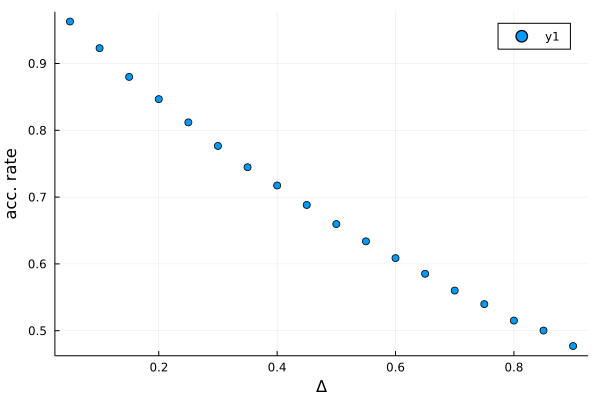

In [54]:
# Get acceptance rate ~ 0.5
Δ_vec = collect(0.05:0.05:0.9)
acc_tab = Sampling.MC_Δ_scan(Δ_vec,w,P0mc,10^3)
plot(acc_tab[:,1], acc_tab[:,2], xlabel="Δ", ylabel="acc. rate", seriestype = :scatter)

┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: [:identity, :log10]
└ @ Plots /home/an-na/.julia/packages/Plots/J70Ph/src/args.jl:1632


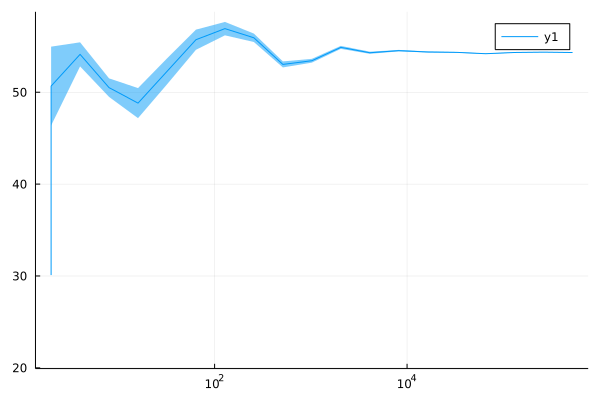

In [55]:

# Get thermalization time

Δ = 0.9
nblocks = 20
mc_energy = Sampling.MC_t_therm(nblocks, w, P0mc, Δ) 
bl_tab = Sampling.block_anal(nblocks, mc_energy)

p1 = plot(bl_tab[:,1], bl_tab[:,2], ribbon=bl_tab[:,3],fillalpha=.5, xscale =:log) 
plot(p1)

In [56]:
# Sampling using MCMC

mc_energy = nothing
bl_tab = nothing
mc_out = nothing

Δ = 0.1
Nconf = 5 * 10^5
Twait = 10^6

mc_out = Sampling.MC_sim(w, P0mc, Twait, Δ; N_iter=Nconf);

In [57]:
# Compute statistics

av_mc, va_mc, cov_mc = Sampling.compute_statistics(mc_out, N, M);

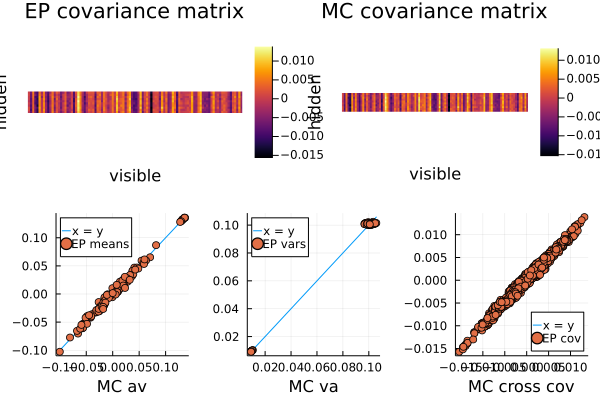

In [58]:

p1 = heatmap(cov_ep', aspect_ratio=1, ticks= :false, showaxis = :false, xlabel = "visible", ylabel = "hidden" ,title="EP covariance matrix", titlelocation=:center)
p2 = heatmap(cov_mc', aspect_ratio=1, ticks= :false, xlabel = "visible", ylabel = "hidden", showaxis =:false,  title="MC covariance matrix", titlelocation=:center)
p3 = Plots.plot(av_mc, av_mc, label = "x = y") 
p3 = Plots.plot!(av_mc, out.av, seriestype = :scatter, label = "EP means", legend = :topleft, xlabel = "MC av")
p4 = Plots.plot(va_mc, va_mc, label = "x = y")
p4 = Plots.plot!(va_mc, out.va, seriestype = :scatter, label = "EP vars", legend = :topleft, xlabel = "MC va")
p5 = Plots.plot(vec(cov_mc), vec(cov_mc), label = "x = y")
p5 = Plots.plot!(vec(cov_mc), vec(cov_ep), seriestype = :scatter, label = "EP cov", legend = :bottomright, xlabel = "MC cross cov")
l = @layout [a b; c d e]
Plots.plot(p1,p2,p3, p4, p5, layout = l)

# (Pv, Ph) = (SpikeAndSlab, ReLu) priors

In [59]:

# Number of visible and hidden units, Gaussian weigths
#N = convert(Int,28*28*0.5)
#M = convert(Int,400*0.5)
N = 100
M = 10
w = randn(N,M)
y = zeros(N+M)
H = [GaussianEP.TermRBM(w,y,1.0)];
γ = 50.0
ρ = 1.0/21
λ = 50.0
Pv = [GaussianEP.SpikeSlabPrior(ρ, λ, 0.0, 1e-3) for i = 1:N]
Ph = [GaussianEP.ReLUPrior(γ, 0.0, 1e-3, 1e-3) for i = 1:M]


10-element Array{ReLUPrior{Float64},1}:
 ReLUPrior{Float64}(50.0, 0.0, 0.001, 0.001, 0.0, 0.0)
 ReLUPrior{Float64}(50.0, 0.0, 0.001, 0.001, 0.0, 0.0)
 ReLUPrior{Float64}(50.0, 0.0, 0.001, 0.001, 0.0, 0.0)
 ReLUPrior{Float64}(50.0, 0.0, 0.001, 0.001, 0.0, 0.0)
 ReLUPrior{Float64}(50.0, 0.0, 0.001, 0.001, 0.0, 0.0)
 ReLUPrior{Float64}(50.0, 0.0, 0.001, 0.001, 0.0, 0.0)
 ReLUPrior{Float64}(50.0, 0.0, 0.001, 0.001, 0.0, 0.0)
 ReLUPrior{Float64}(50.0, 0.0, 0.001, 0.001, 0.0, 0.0)
 ReLUPrior{Float64}(50.0, 0.0, 0.001, 0.001, 0.0, 0.0)
 ReLUPrior{Float64}(50.0, 0.0, 0.001, 0.001, 0.0, 0.0)

In [60]:

out = GaussianEP.expectation_propagation(H, Pv, Ph, epsconv = 1e-5, nprint = 100)

cov_ep = zeros(N,M)
for i = 1:N, j = 1:M
	cov_ep[i,j] = out.state.Σ[i,N+j] + out.state.av[i] * out.state.av[N+j]
end


In [61]:


γ_m = Ph[1].γ
θ_m = Ph[1].θ
λ_m = Pv[1].λ
println("γ: ",γ_m, " θ: ", θ_m, " λ: ", λ_m)
Pv = [Sampling.SpikeSlabPrior(ρ, λ_m) for i = 1:N]
Ph = [Sampling.ReLUPrior(γ_m, θ_m) for j = 1:M ]
P0mc = vcat(Pv,Ph);

γ: 49.995518410092444 θ: 0.03510827866631845 λ: 49.999982768650675


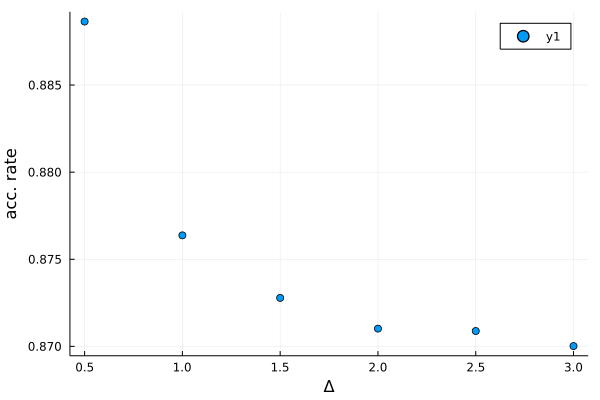

In [62]:

# Get acceptance rate ~ 0.5
Δ_vec = collect(0.5:0.5:3.0)
acc_tab = Sampling.MC_Δ_scan(Δ_vec,w,P0mc,10^3)
plot(acc_tab[:,1], acc_tab[:,2], xlabel="Δ", ylabel="acc. rate", seriestype = :scatter)

┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: [:identity, :log10]
└ @ Plots /home/an-na/.julia/packages/Plots/J70Ph/src/args.jl:1632


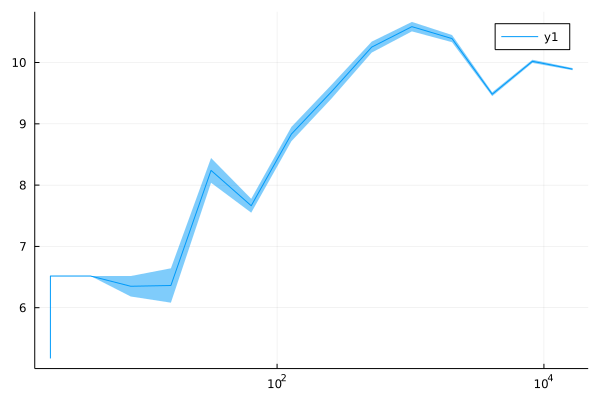

In [63]:
# Get thermalization time

Δ = 3.5
nblocks = 15
mc_energy = Sampling.MC_t_therm(nblocks, w, P0mc, Δ) 
bl_tab = Sampling.block_anal(nblocks, mc_energy)

p1 = plot(bl_tab[:,1], bl_tab[:,2], ribbon=bl_tab[:,3],fillalpha=.5, xscale =:log) 
plot(p1)

In [64]:
# Sampling using MCMC
mc_energy = nothing
bl_tab = nothing
mc_out = nothing

Δ = 3.5
Nconf = 10^6
Twait = 10^5

@time mc_out = Sampling.MC_sim(w, P0mc, Twait, Δ; N_iter=Nconf);

 67.372651 seconds (714.99 M allocations: 60.819 GiB, 12.08% gc time)


In [65]:
# Compute statistics

@time av_mc, va_mc, cov_mc = Sampling.compute_statistics(mc_out, N, M);

  8.921570 seconds (4.45 k allocations: 16.555 GiB, 2.01% gc time)


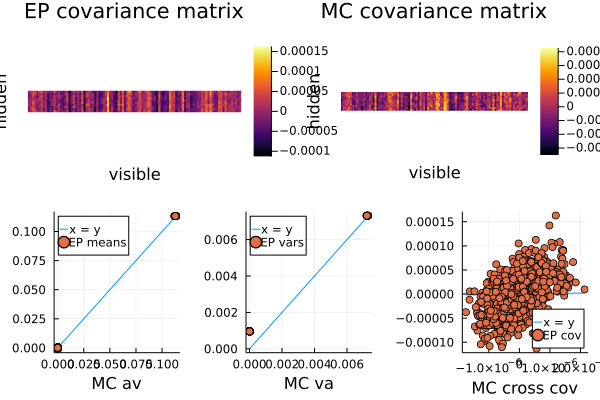

In [66]:
p1 = heatmap(cov_ep', aspect_ratio=1, ticks= :false, showaxis = :false, xlabel = "visible", ylabel = "hidden" ,title="EP covariance matrix", titlelocation=:center)
p2 = heatmap(cov_mc', aspect_ratio=1, ticks= :false, xlabel = "visible", ylabel = "hidden", showaxis =:false,  title="MC covariance matrix", titlelocation=:center)
p3 = Plots.plot(av_mc, av_mc, label = "x = y") 
p3 = Plots.plot!(av_mc, out.av, seriestype = :scatter, label = "EP means", legend = :topleft, xlabel = "MC av")
p4 = Plots.plot(va_mc, va_mc, label = "x = y")
p4 = Plots.plot!(va_mc, out.va, seriestype = :scatter, label = "EP vars", legend = :topleft, xlabel = "MC va")
p5 = Plots.plot(vec(cov_mc), vec(cov_mc), label = "x = y")
p5 = Plots.plot!(vec(cov_mc), vec(cov_ep), seriestype = :scatter, label = "EP cov", legend = :bottomright, xlabel = "MC cross cov")
l = @layout [a b; c d e]
Plots.plot(p1,p2,p3, p4, p5, layout = l)

# (Pv, Ph) = (Gaussian, Spike and Slab)

In [67]:

# Number of visible and hidden units, Gaussian weigths
#N = 30
#M = 15
N = 100
M = 10
w = randn(N,M)
y = zeros(N+M)
H = [GaussianEP.TermRBM(w,y,1.0)];
ρ = 0.2
λ = 20.0
μv = 0.5
βv = 50.0

Ph = [GaussianEP.SpikeSlabPrior(ρ, λ) for i = 1:M]
Pv = [GaussianEP.GaussianPrior(μv, βv, 0.0) for i = 1:N];


In [68]:
out = GaussianEP.expectation_propagation(H, Pv, Ph, nprint = 100);

cov_ep = zeros(N,M)
for i = 1:N, j = 1:M
	cov_ep[i,j] = out.state.Σ[i,N+j] + out.state.av[i] * out.state.av[N+j]
end

it: 100 Δav: 1.824657459570389e-6 Δgrad: 0.0


In [69]:

Ph = [Sampling.SpikeSlabPrior(ρ, λ) for i = 1:M]
Pv = [Sampling.GaussianPrior(μv, βv, 0.0) for i = 1:N];
P0mc = vcat(Pv,Ph);

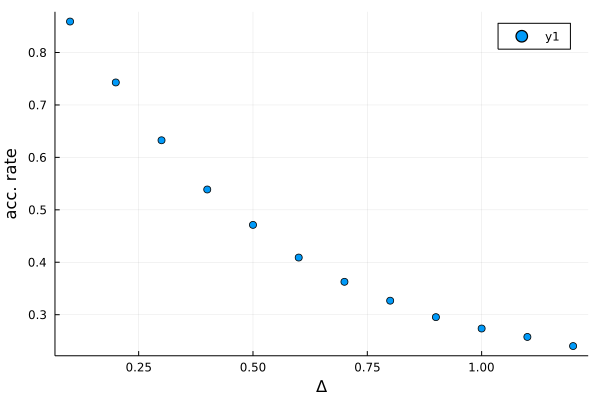

In [70]:

# Get acceptance rate ~ 0.5
Δ_vec = collect(0.1:0.1:1.2)
acc_tab = Sampling.MC_Δ_scan(Δ_vec,w,P0mc,10^3)
plot(acc_tab[:,1], acc_tab[:,2], xlabel="Δ", ylabel="acc. rate", seriestype = :scatter)

┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: [:identity, :log10]
└ @ Plots /home/an-na/.julia/packages/Plots/J70Ph/src/args.jl:1632


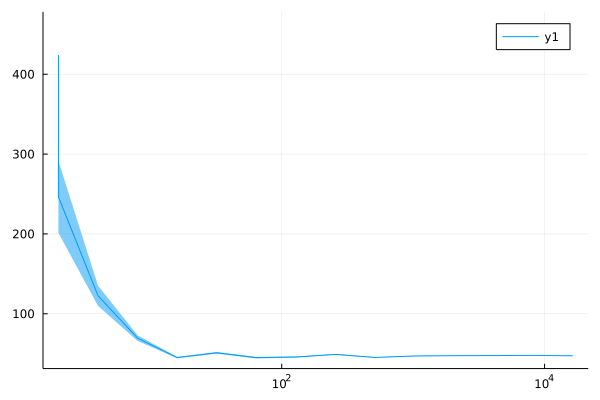

In [71]:
# Get thermalization time

Δ = 1.2
nblocks = 15
mc_energy = Sampling.MC_t_therm(nblocks, w, P0mc, Δ) 
bl_tab = Sampling.block_anal(nblocks, mc_energy)

p1 = plot(bl_tab[:,1], bl_tab[:,2], ribbon=bl_tab[:,3],fillalpha=.5, xscale =:log) 
plot(p1)

In [72]:

# Sampling using MCMC
mc_energy = nothing
bl_tab = nothing
mc_out = nothing

Nconf = 5*10^6
Twait = 10^4

mc_out = Sampling.MC_sim(w, P0mc, Twait, Δ; N_iter=Nconf);

In [73]:
# Compute statistics

av_mc, va_mc, cov_mc = Sampling.compute_statistics(mc_out, N, M);

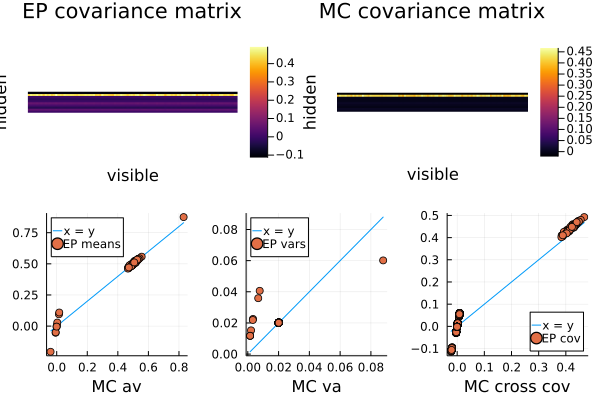

In [74]:
p1 = heatmap(cov_ep', aspect_ratio=1, ticks= :false, showaxis = :false, xlabel = "visible", ylabel = "hidden" ,title="EP covariance matrix", titlelocation=:center)
p2 = heatmap(cov_mc', aspect_ratio=1, ticks= :false, xlabel = "visible", ylabel = "hidden", showaxis =:false,  title="MC covariance matrix", titlelocation=:center)
p3 = Plots.plot(av_mc, av_mc, label = "x = y") 
p3 = Plots.plot!(av_mc, out.av, seriestype = :scatter, label = "EP means", legend = :topleft, xlabel = "MC av")
p4 = Plots.plot(va_mc, va_mc, label = "x = y")
p4 = Plots.plot!(va_mc, out.va, seriestype = :scatter, label = "EP vars", legend = :topleft, xlabel = "MC va")
p5 = Plots.plot(vec(cov_mc), vec(cov_mc), label = "x = y")
p5 = Plots.plot!(vec(cov_mc), vec(cov_ep), seriestype = :scatter, label = "EP cov", legend = :bottomright, xlabel = "MC cross cov")
l = @layout [a b; c d e]
Plots.plot(p1,p2,p3, p4, p5, layout = l)